## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Redes convolucionales


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas convolucionales (CNN). Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/). 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

### Nombres:

#### Angie Paola Chacón -201012536
#### Juan Sebastian Rincón -201214767
#### Carolina Padilla Hernández -201111402

Importemos algunos de los paquetes que vamos a utilizar:


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)

Using TensorFlow backend.


In [4]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Redes convolucionales

Las redes convolucionales (CNN: *Convolutional Neural Nets*) es un tipo de red neuronal (profunda) que suele usarse para el tratamiento de imagenes y la vision computacional, pero que también sirve para otras tareas como el procesamiento de datos secuenciales, lenguage natural, datos geo-referenciados o datos estructurados que guarden ciertas correlaciones entre sí (ver por ejemplo W. Kim (2014) Convolutional Neural Networks for Sentence Classification). 

Se les concoce por ser invariantes a translaciones, de tal manera que con su arquitectura producen exactamente la misma respuesta ante diferentes traslaciones (como por ejemplo rotaciones) que se le aplique a los datos de entrada. 

Un aspecto importante para entender las CNN de la mano con el tema que hemos visto hasta ahora en el curso, consiste en entender que los pesos y sesgos de una *capa convolucional* son **filtros** que extraen patrones particulares de los datos de entrada. Luego de la extracción de patrones, la red cuenta con capas densamente conectadas donde distintas neuronas pueden compartir el mismo filtro. 

Veamos:
https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

Entonces, las CNN se pueden entender como versiones regularizadas de las redes multi-capa *densamente conectadas* (donde cada neurona en una capa está conectada con todas las demás neuronas de la siguiente capa). Este tipo de conexión *densa* facilita el *sobre-ajuste* a los datos de muestra con los que se construyen los mdoelos. Así, las CNN se enfocan en construir patrones más complejos pero más simples, encontrando *areas* de atención en las que enfocarse, haciendo uso de filtros y de **convoluciones** (formalmente hablando, una convolución corresponde con la operación matemática de la correlación cruzada). 

Veamos un ejemplo con un filtro de $3\times 3$ y una *stride* de 1:


$$ Imagen = \begin{bmatrix}
    1  & 1  & 1 & 0 & 0\\
    0 & 1 & 1 & 1 & 0 \\
    0  & 0 & 1  & 1 & 1 \\
    0 & 0 & 1 & 1 & 0 \\
    0  & 1 & 1  & 0 & 0
\end{bmatrix};\;\;\; Filtro = \begin{bmatrix}
    1  & 0  & 1\\
    0  & 1 & 0 \\
    1  & 0 & 1 
\end{bmatrix}; \;\;\; Patron =\begin{bmatrix}
    4  & 3  & 4\\
    2  & 4 & 3 \\
    2  & 3 & 4 
\end{bmatrix}$$

Para obtener el nuevo patrón convolucionado, resolvemos la operación $\otimes_1$ denotando una convolución con un *stride* de 1, o una *ventana móvil de 1 en 1*, tal que $Patron = Imagen \otimes_1 Filtro$.



Además de la operación convolucional, tras una capa convolucional le suele seguir un filtro de agregación conocido como **pooling**. Este filtro también toma ventanas móviles y resume los valores dentro de su rango de acuerdo con una operación de agregación específica.

Por ejmplo, un *Max-pooling* consiste en tomar el máximo dentro de cada ventana. Si tomamos un filtro de Max-pooling de tamaño $2\times 2$ y un *stride* de 2, y lo aplicamos sbre el patrón $P$, obtenemos:

$$ P = \begin{bmatrix}
    5  & 4  & 6 & 3\\
    3  & 9 & 4 & 5 \\
    8  & 1 & 7  & 9  \\
    0 & 2 & 8 & 0  
\end{bmatrix}\;\;\; $$

$$ MaxPool_{2\times 2}^{stride=2}(P) = \begin{bmatrix}
    9  & 6\\
    8  & 9
\end{bmatrix}$$


La gran ventaja de las CNN es que aprenden de manera automática (sin necesidad de conocimiento previo) los filtros que de otro modo habría que especificar explícita o manualmente. 

Especifiquemos a continuación la arquitectura de nuestra CNN, donde vamos a hacer uso de una técnica de **Drop-out** antes de la capa de salida. Esta técnica elimina aleatoriamente y de manera temporal (en cada iteración) un número de neuronas determinado (por una tasa de eliminación o *drop-out*), con el fin de que el modelo no recaiga demasidado en ciertas neuronas y generalize de la mejor manera la función a estimar :

In [3]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

Instructions for updating:
Colocations handled automatically by placer.


### Optimizador de Adam

Vamos a implementar la red convolucional con la arquitectura especificada arriba haciendo uso del método de optimización estocástica de **Adam** (Kingma & Ba (2015)). El término *Adam* se debe a *Adaptive Moment Estimation*, y se puede entender como una revisión al método de RMSProp. Bajo Adam, se utilizan promedios móviles tanto de los gradientes como de sus segundos momentos.  De esta manera, se tiene que 

$$ u(\theta) = \rho_1 u(\theta_{viejo}) + (1-\rho_1) \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }  $$

$$ v(\theta) = \rho_2 v(\theta_{viejo}) + (1-\rho_2) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$

donde

$$ \hat u = \frac{u(\theta)}{1-\rho_1^t} $$

$$ \hat v = \frac{v(\theta)}{1-\rho_2^t} $$

De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\hat u}{\sqrt{\hat v}+\varepsilon}$$ 

donde $\varepsilon$ es un escalar muy pequeño (infinitesimal) que previene la división por cero, $\rho_1, \rho_2$ son respectivamente  los factores de memoria sobre el primer y segundo momento de los gradientes. 

In [6]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 19 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715 , loss_v1=1.2310980502012614 , loss_v2=1.155707528293868
Epoca= 42 , accu_v1=0.837837815284729 , accu_v2=0.7631579041481018 , loss_v1=0.28997523800746816 , loss_v2=0.5117824140347933
Epoca= 66 , accu_v1=0.8648648858070374 , accu_v2=0.9210526347160339 , loss_v1=0.5365556494358021 , loss_v2=0.26963682237424347
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8649 | 0.8684 |   19  |
|  0.96  | 0.8378 | 0.7632 |   42  |
|  1.0   | 0.8649 | 0.9211 |   66  |
+--------+--------+--------+-------+


### Pregunta 3.1

Qué puede observar sobre estos resultados?

#### R/
En la tabla se observa que no existe convergencia en la red, ya que al realizar la validación cruzada la exactitud en el entrenamiento "Exact_E" es distinto en una particióncon un valor de 0.96. Es decir, que la red alcanza aprender bien la estructura de los datos pero no se lleva a cabo de la misma manera en todas las particiones.  

Visualicemos el mejor resultado

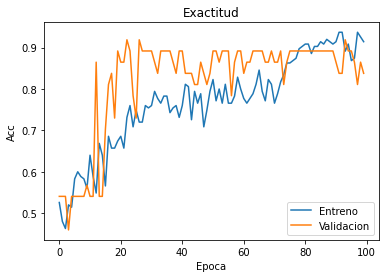

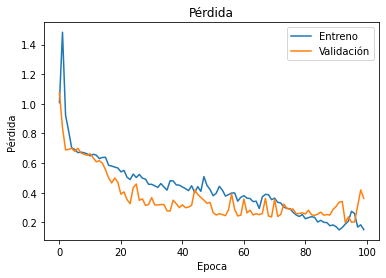

In [5]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [6]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [7]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[140,   5],
       [  4, 101]], dtype=int64)

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 134 </td>
       <td> 11 </td>
    </tr>
    <tr>
       <td> 4 </td>
       <td> 101 </td>
    </tr>

</table>

### Ejercicio 1.1

Intente hacer que el optimizador Adam converja en todas las repeticiones. 


#### Se modifica los inicializadores

* Randon Normal 

In [15]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [16]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 51 , accu_v1=0.9189189076423645 , accu_v2=0.8947368264198303 , loss_v1=0.396843599133914 , loss_v2=0.7905217990818002
Epoca= 66 , accu_v1=0.837837815284729 , accu_v2=0.8684210777282715 , loss_v1=0.7378636308618494 , loss_v2=0.8020336063284623
Epoca= 97 , accu_v1=0.8918918967247009 , accu_v2=0.9473684430122375 , loss_v1=0.20734106547929146 , loss_v2=0.1356663421580666
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.9189 | 0.8947 |   51  |
| 0.9943 | 0.8378 | 0.8684 |   66  |
|  1.0   | 0.8919 | 0.9474 |   97  |
+--------+--------+--------+-------+


* He 

In [17]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initHe, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [18]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 18 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715 , loss_v1=0.6686702371650451 , loss_v2=0.7481272524271748
Epoca= 99 , accu_v1=0.9189189076423645 , accu_v2=0.8421052694320679 , loss_v1=0.222473153794134 , loss_v2=0.4113767241176806
Epoca= 58 , accu_v1=0.8918918967247009 , accu_v2=0.9473684430122375 , loss_v1=0.533365275424404 , loss_v2=0.360941817885951
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8919 | 0.8684 |   18  |
| 0.9771 | 0.9189 | 0.8421 |   99  |
|  1.0   | 0.8919 | 0.9474 |   58  |
+--------+--------+--------+-------+


* Inicialización en Ceros

In [19]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Inicializacion de Zeros

initzeros = keras.initializers.Zeros()

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initzeros, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initzeros, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [20]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 0 , accu_v1=0.4324324429035187 , accu_v2=0.6052631735801697 , loss_v1=0.7269984934781049 , loss_v2=0.6723016406360426
Epoca= 0 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697 , loss_v1=0.7163088869404148 , loss_v2=0.6728327556660301
Epoca= 9 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285 , loss_v1=0.6935300988120001 , loss_v2=0.6630301193187111
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.6057 | 0.4324 | 0.6053 |   0   |
|  0.6   | 0.4595 | 0.6053 |   0   |
| 0.5771 | 0.5405 | 0.6316 |   9   |
+--------+--------+--------+-------+


#### R//  
Al probar diferente conbinación de inicializadores, se observa que dejando en todas las capas el inicializador *Random Normal* , este converge en todas las particiones. Por otro lado, remplazar la inicialización *He* con ceros hace que la red neuronal converja pero su exactitud se ve reducida considerablemente y se genera un sobreajuste en el modelo. En conclusión, el inicializador *He* hace que no converja el modelo.  

### Ejercicio 1.2

Compare los resultados al utilizar otros algoritmos de aprendizaje como RMSprop o el mismo SGD


In [23]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

##### SGD

In [24]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del SGD
sgd = SGD(lr=0.01, momentum=0.001)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 80 , accu_v1=0.8108108043670654 , accu_v2=0.8421052694320679
Epoca= 97 , accu_v1=0.8648648858070374 , accu_v2=0.8157894611358643
Epoca= 96 , accu_v1=0.8108108043670654 , accu_v2=0.8947368264198303
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9314 | 0.8108 | 0.8421 |   80  |
|  0.96  | 0.8649 | 0.8158 |   97  |
| 0.9486 | 0.8108 | 0.8947 |   96  |
+--------+--------+--------+-------+


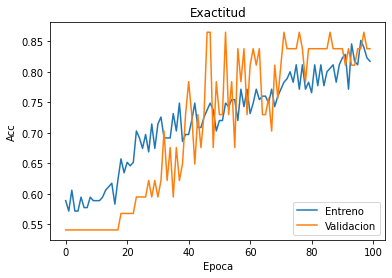

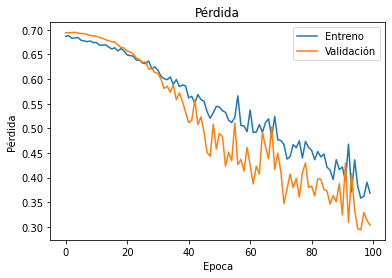

In [25]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [27]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)             

In [28]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [ 19,  86]], dtype=int64)

#### RMSPROP

In [29]:
from tensorflow.keras import optimizers
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del SGD
rms = keras.optimizers.RMSprop(learning_rate=0.001)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 18 , accu_v1=0.7837837934494019 , accu_v2=0.8684210777282715
Epoca= 30 , accu_v1=0.8108108043670654 , accu_v2=0.7894737124443054
Epoca= 23 , accu_v1=0.837837815284729 , accu_v2=0.8157894611358643
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.7838 | 0.8684 |   18  |
| 0.9657 | 0.8108 | 0.7895 |   30  |
|  1.0   | 0.8378 | 0.8158 |   23  |
+--------+--------+--------+-------+


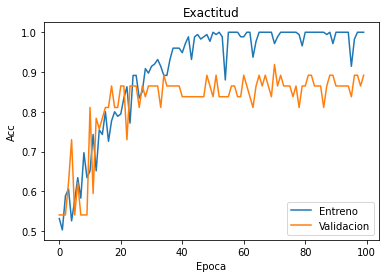

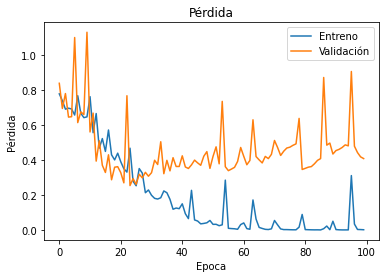

In [30]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [31]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)             

In [32]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[140,   5],
       [  8,  97]], dtype=int64)

### R// 

Manteninendo la inicializacion en *Random Normal* y al probar diferentes optimizadores como el SGD y RMSPROP se observa que Adam brinda los mejores resultados al modelo, esto se debe a que SGD no se ajusta muy bien después de las 60 epocas, posiblemente por la baja tasa de aprendizaje, y por otro lado, con RMSPROP la pérdida de abandono deja de disminuir después de las 20 épocas y la precisión queda constante en el mismo periodo, por lo tanto no es recomendable usarlo.    

### Ejercicio 1.3

Compare los resultados con distintas tasas de *drop-out*.  

##### Drop-out: 0.9

In [33]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dropout(rate=0.9, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [34]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 77 , accu_v1=0.837837815284729 , accu_v2=0.8947368264198303 , loss_v1=0.6912623875447221 , loss_v2=0.33610374637340246
Epoca= 3 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697 , loss_v1=0.7166494066650803 , loss_v2=0.672741102544885
Epoca= 1 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285 , loss_v1=0.6932669990771526 , loss_v2=0.6633417700466356
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8947 |   77  |
|  0.6   | 0.4595 | 0.6053 |   3   |
| 0.5771 | 0.5405 | 0.6316 |   1   |
+--------+--------+--------+-------+


##### Drop-out: 0.5

In [35]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dropout(rate=0.5, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [36]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 54 , accu_v1=0.9459459185600281 , accu_v2=0.9210526347160339 , loss_v1=0.6219844781346084 , loss_v2=0.6867520680711765
Epoca= 0 , accu_v1=0.45945945382118225 , accu_v2=0.6052631735801697 , loss_v1=0.7149119989292042 , loss_v2=0.6732377723643654
Epoca= 72 , accu_v1=0.8648648858070374 , accu_v2=0.9210526347160339 , loss_v1=0.4420848246663809 , loss_v2=0.28633187005394384
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.9459 | 0.9211 |   54  |
|  0.6   | 0.4595 | 0.6053 |   0   |
|  1.0   | 0.8649 | 0.9211 |   72  |
+--------+--------+--------+-------+


##### Drop-out: 0.01

In [37]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(Dropout(rate=0.01, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [38]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p) +' , loss_v1='+str(loss_v) +' , loss_v2='+str(loss_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Epoca= 18 , accu_v1=0.837837815284729 , accu_v2=0.9210526347160339 , loss_v1=0.8414579968194704 , loss_v2=0.8150217355662455
Epoca= 61 , accu_v1=0.8108108043670654 , accu_v2=0.8157894611358643 , loss_v1=0.6227956784738077 , loss_v2=0.7132166498585751
Epoca= 94 , accu_v1=0.8918918967247009 , accu_v2=0.8947368264198303 , loss_v1=0.2584692271476662 , loss_v2=0.4265766081057097
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.9211 |   18  |
|  1.0   | 0.8108 | 0.8158 |   61  |
|  1.0   | 0.8919 | 0.8947 |   94  |
+--------+--------+--------+-------+


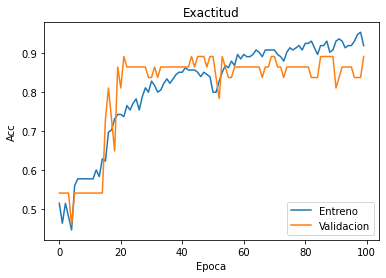

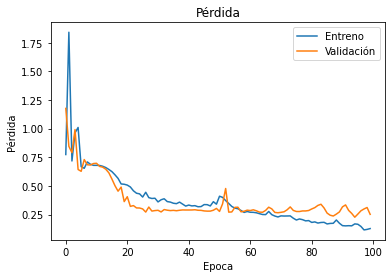

In [39]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [40]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.h5')

model_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3136)            

In [41]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[140,   5],
       [  4, 101]], dtype=int64)

#### R//

Al usar diferentes tasas de dopout o abandono se observa que la mejor es la de 0.2, esta tasa le permite al modelo regularizarse omitiendo aleatoreamente algunas neuronas que actuán como dectores de caracteristicas de la red neuronal durante cada paso de entrenamiento, previniendo que el modelo se sobreajuste. Se recomienda para las capas intermedias eligir entre 0.5-0.2. En la capa de entrada se recomienda un dropout entre 0.2 o menos porque eliminar datos a la entrada puede afectar el entrenamiento. Por otro lado, tener una tasa tan pequeña, no genera la regularización esperada llevando al sobreajuste del modelo. Por lo tanto, para nuestro modelo la tasa de dropout optima es 0.2

### Bono

Visualice los distintos filtros convolucionales para entender qué tipo de patrones están aprendiendo que son relevantes para la detección de frailejones.

*A continuación se indica cómo visulizar una capa convolucional. Examine las distintas capas convolucionales y analice lo que puede visualizar.*

In [8]:
from matplotlib import pyplot

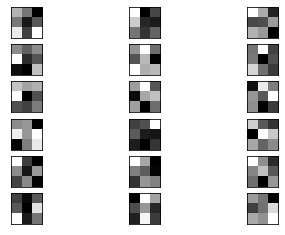

In [9]:

# cargamos los pesos de la primera capa escondida
filters, biases = model_3.layers[0].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 6, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [1]:
from keras.preprocessing.image import image

#img = image.load_img('IMG_3451.JPG')
#img 

Using TensorFlow backend.


### Red Convolucional

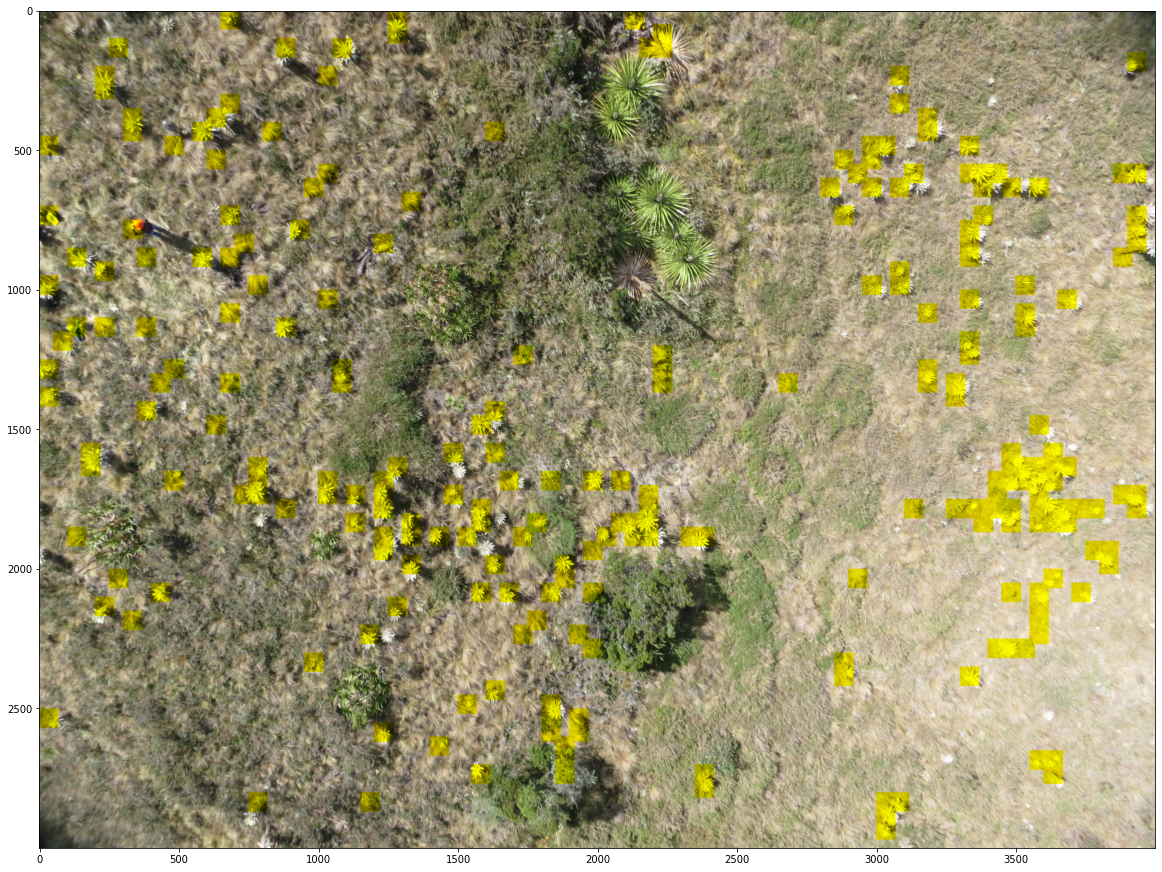

In [11]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_3.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf
        

Despues de utilizar redes convulocinonales, la precisión identificando frailejones aumenta, se observa que se ha reducido la confusión de frailejones en espacios con arboles, a pesar de que sigue confundiendo a la persona con un frailejon. Por lo tanto, se deberia incrementar la información de entrenamiento con nuevas fotografias o rotaciones de imagenes actuales, para exponer a la red a una mator variedad de posibilidades para que así deje de identificar caracteristicas no deseadas. 